In [1]:
import torch
import torchaudio
import torchaudio.functional as F

print(torch.__version__)
print(torchaudio.__version__)

2.0.0+cu117
2.0.1+cu117


In [2]:
from pesq import pesq
from pystoi import stoi
import mir_eval
import matplotlib.pyplot as plt
from IPython.display import Audio
from torchaudio.utils import download_asset

In [3]:
# Downloading Audio data
SAMPLE_RATE = 16000
SAMPLE_CLEAN = download_asset("tutorial-assets/mvdr/clean_speech.wav")
SAMPLE_NOISE = download_asset("tutorial-assets/mvdr/noise.wav")

In [15]:
# Helper functions
def plot_spectrogram(stft, title="Spectrogram", xlim=None):
    magnitude = stft.abs()
    spectrogram = 20 * torch.log10(magnitude + 1e-8).numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(spectrogram, cmap="viridis", vmin=-100, vmax=0, origin="lower", aspect="auto")
    figure.suptitle(title)
    plt.colorbar(img, ax=axis)
    plt.show()


def plot_mask(mask, title="Mask", xlim=None):
    mask = mask.numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(mask, cmap="viridis", origin="lower", aspect="auto")
    figure.suptitle(title)
    plt.colorbar(img, ax=axis)
    plt.show()
    
def si_snr(estimate, reference, epsilon=1e-8):
    estimate = estimate - estimate.mean()
    reference = reference - reference.mean()
    reference_pow = reference.pow(2).mean(axis=1, keepdim=True)
    mix_pow = (estimate * reference).mean(axis=1, keepdim=True)
    scale = mix_pow / (reference_pow + epsilon)

    reference = scale * reference
    error = estimate - reference

    reference_pow = reference.pow(2)
    error_pow = reference.pow(2)

    reference_pow = reference_pow.mean(axis=1)
    error_pow = error_pow.mean(axis=1)

    si_snr = 10 * torch.log10(reference_pow) - 10 * torch.log10(error_pow)
    return si_snr.item()
    

def generate_mizture(waveform_clean, waveform_noise, target_snr):
    power_clean_signal = waveform_clean.pow(2).mean()
    power_noise_signal = waveform_noise.pow(2).mean()
    current_snr = 10 * torch.log10(power_clean_signal / power_noise_signal)
    waveform_noise *= 10 ** (-(target_snr - current_snr / 20))
    return waveform_clean + waveform_noise

def evaluate(estimate, reference):
    si_snr_score = si_snr(estimate, reference)
    (sdr, _, _, _) = mir_eval.separation.bss_eval_sources(reference.numpy(), estimate.numpy(), False)
    pesq_mix = pesq(SAMPLE_RATE, estimate[0].numpy(), reference[0].numpy(), "wb")
    stoi_mix = stoi(reference[0].numpy(), estimate[0].numpy(), SAMPLE_RATE, extended=False)
    print(f"SDR score: {sdr[0]}")
    print(f"Si-SNR score: {si_snr_score}")
    print(f"PESQ score: {pesq_mix}")
    print(f"STOI score: {stoi_mix}")


In [16]:
# Loading audio data
waveform_clean, sr = torchaudio.load(SAMPLE_CLEAN)
waveform_noise, sr2 = torchaudio.load(SAMPLE_NOISE)

print(waveform_clean)
print(waveform_noise)

assert sr == sr2 == SAMPLE_RATE
target_snr = 3
waveform_mix = generate_mizture(waveform_clean, waveform_noise, target_snr)



tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0005, -0.0005, -0.0004],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0005, -0.0005, -0.0005],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0005, -0.0005, -0.0005],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0004, -0.0004, -0.0005],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0004, -0.0004, -0.0004],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0004, -0.0004, -0.0004]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [17]:
waveform_mix = waveform_mix.to(torch.double)
waveform_clean = waveform_clean.to(torch.double)
waveform_noise = waveform_noise.to(torch.double)

print(waveform_mix)
print(waveform_clean)
print(waveform_noise)

tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0005, -0.0005, -0.0004],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0005, -0.0005, -0.0005],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0005, -0.0005, -0.0005],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0004, -0.0004, -0.0005],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0004, -0.0004, -0.0004],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0004, -0.0004, -0.0004]],
       dtype=torch.float64)
tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0005, -0.0005, -0.0004],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0005, -0.0005, -0.0005],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0005, -0.0005, -0.0005],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0004, -0.0004, -0.0005],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0004, -0.0004, -0.0004],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0004, -0.0004, -0.0004]],
       dtype=torch.float64)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0

In [18]:
# Compute STFT coefficients
N_FFT = 1024
N_HOP = 256

stft = torchaudio.transforms.Spectrogram(
    n_fft=N_FFT,
    hop_length=N_HOP,
    power=None
)

istft = torchaudio.transforms.InverseSpectrogram(n_fft=N_FFT, hop_length=N_HOP)

stft_mix = stft(waveform_mix)
stft_clean = stft(waveform_clean)
stft_noise = stft(waveform_noise)

print(stft_mix)

tensor([[[ 2.5178e-02+0.0000e+00j,  3.5267e-02+0.0000e+00j,
           5.6841e-03+0.0000e+00j,  ...,
           2.1703e-02+0.0000e+00j,  6.1165e-02+0.0000e+00j,
           5.1008e-02+0.0000e+00j],
         [ 1.6040e-02+1.0915e-08j, -4.4392e-02+1.0044e-02j,
          -5.0677e-03-3.9655e-02j,  ...,
          -2.8612e-02+4.9418e-02j, -3.7996e-02-1.2818e-02j,
          -1.9445e-02+7.4353e-05j],
         [-8.6406e-02+2.5218e-08j,  4.8129e-02+2.3057e-02j,
           2.0911e-02-2.1882e-03j,  ...,
           4.6119e-02-3.9915e-02j, -6.4857e-03-5.4895e-03j,
          -2.7038e-02-4.2339e-04j],
         ...,
         [ 2.8369e-03-6.0503e-09j, -2.7385e-03+4.0753e-03j,
           1.5961e-03-3.5327e-03j,  ...,
          -8.0715e-06+1.7099e-04j,  1.8154e-04-1.2033e-04j,
          -2.8906e-04+2.9118e-06j],
         [ 3.6865e-03-1.5388e-08j,  2.7838e-03-2.9580e-03j,
          -4.2919e-04+7.5556e-04j,  ...,
          -9.5010e-05-1.4510e-04j, -1.9178e-04+1.9590e-04j,
           2.1334e-04-2.4099e-06j],
 

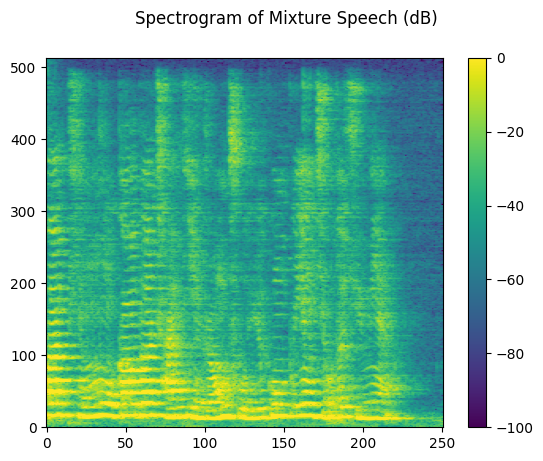

SDR score: 61.07860543238348
Si-SNR score: 0.0
PESQ score: 4.643888473510742
STOI score: 0.9999804638562682


In [22]:
plot_spectrogram(stft_mix[0], title="Spectrogram of Mixture Speech (dB)")
evaluate(waveform_mix[0:1], waveform_clean[0:1])
Audio(waveform_mix[0], rate=SAMPLE_RATE)

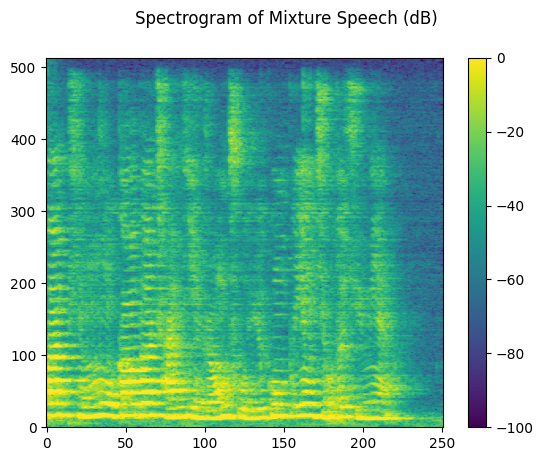

In [21]:
plot_spectrogram(stft_clean[0], "Spectrogram of Mixture Speech (dB)")
Audio(waveform_clean[0], rate=SAMPLE_RATE)

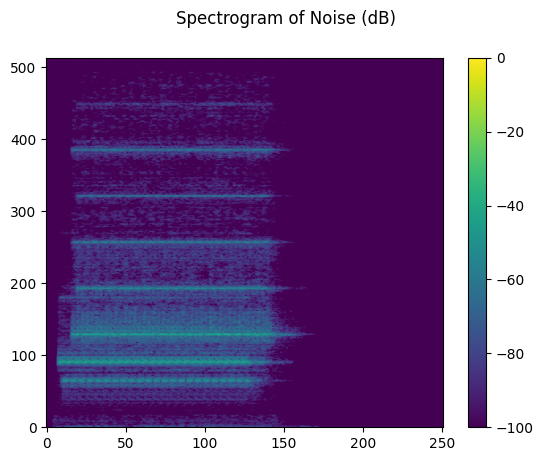

In [23]:
plot_spectrogram(stft_noise[0], "Spectrogram of Noise (dB)")
Audio(waveform_noise[0], rate=SAMPLE_RATE)

In [24]:
REFERENCE_CHANNEL = 0

In [25]:
# Compute IRMs
def get_irms(stft_clean, stft_noise):
    mag_clean = stft_clean.abs() ** 2
    mag_noise = stft_noise.abs() ** 2
    irm_speech = mag_clean / (mag_clean + mag_noise)
    irm_noise = mag_noise / (mag_clean + mag_noise)
    return irm_speech[REFERENCE_CHANNEL], irm_noise[REFERENCE_CHANNEL]

irm_speech, irm_noise = get_irms(stft_clean, stft_noise)

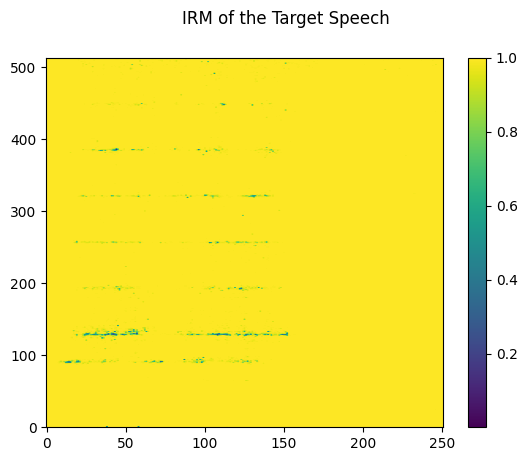

In [26]:
plot_mask(irm_speech, "IRM of the Target Speech")

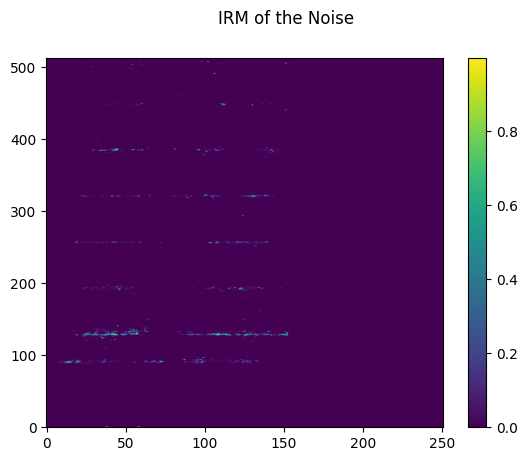

In [27]:
plot_mask(irm_noise, "IRM of the Noise")

In [28]:
# Compute PSD matrices
psd_transform = torchaudio.transforms.PSD()

psd_speech = psd_transform(stft_mix, irm_speech)
psd_noise = psd_transform(stft_mix, irm_noise)

In [30]:
# Beamforming using SoudenMVDR
mvdr_transform = torchaudio.transforms.SoudenMVDR()
stft_souden = mvdr_transform(stft_mix, psd_speech, psd_noise, REFERENCE_CHANNEL)
waveform_souden = istft(stft_souden, length=waveform_mix.shape[-1])

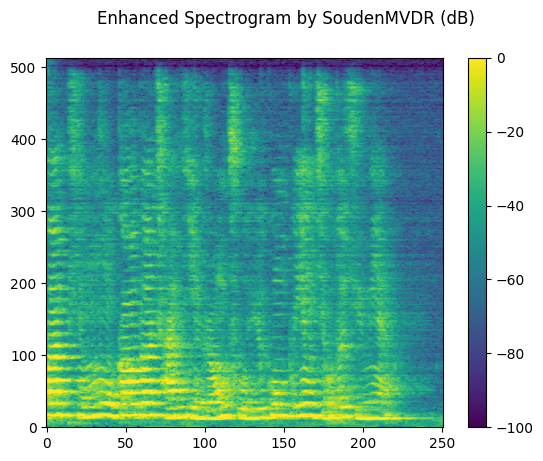

SDR score: 20.155428896279034
Si-SNR score: 0.0
PESQ score: 4.188705921173096
STOI score: 0.9856522438642651


In [31]:
plot_spectrogram(stft_souden, "Enhanced Spectrogram by SoudenMVDR (dB)")
waveform_souden = waveform_souden.reshape(1, -1)
evaluate(waveform_souden, waveform_clean[0:1])
Audio(waveform_souden, rate=SAMPLE_RATE)

In [34]:
# Compute RTF
rtf_evd = F.rtf_evd(psd_speech)
rtf_power = F.rtf_power(psd_speech, psd_noise, REFERENCE_CHANNEL)

In [37]:
mvdr_transform = torchaudio.transforms.RTFMVDR()

stft_rtf_evd = mvdr_transform(stft_mix, rtf_evd, psd_noise, REFERENCE_CHANNEL)
waveform_rtf_evd = istft(stft_rtf_evd, length=waveform_mix.shape[-1])

stft_rtf_power = mvdr_transform(stft_mix, rtf_power, psd_noise, REFERENCE_CHANNEL)
waveform_rtf_power = istft(stft_rtf_power, length=waveform_mix.shape[-1])

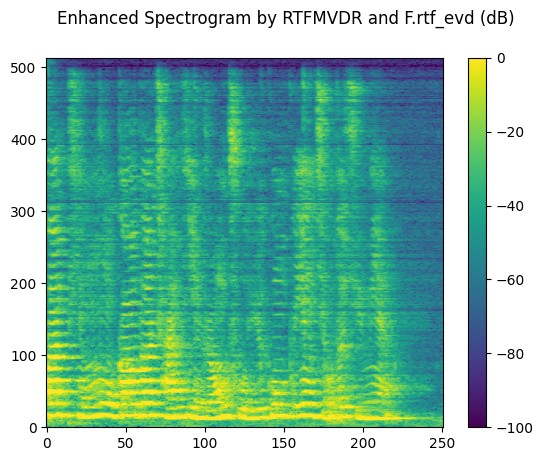

SDR score: 18.76552909927453
Si-SNR score: 0.0
PESQ score: 4.2166428565979
STOI score: 0.9867017859264056


In [38]:
# Result
plot_spectrogram(stft_rtf_evd, "Enhanced Spectrogram by RTFMVDR and F.rtf_evd (dB)")
waveform_rtf_evd = waveform_rtf_evd.reshape(1, -1)
evaluate(waveform_rtf_evd, waveform_clean[0:1])
Audio(waveform_rtf_evd, rate=SAMPLE_RATE)

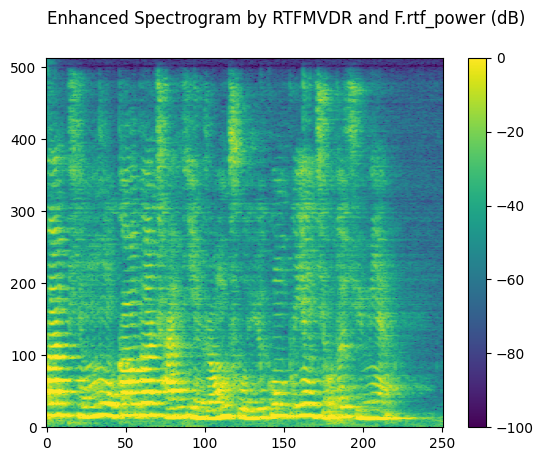

SDR score: 19.78298346512655
Si-SNR score: 0.0
PESQ score: 4.241096496582031
STOI score: 0.9915543861690023


In [39]:
plot_spectrogram(stft_rtf_power, "Enhanced Spectrogram by RTFMVDR and F.rtf_power (dB)")
waveform_rtf_power = waveform_rtf_power.reshape(1, -1)
evaluate(waveform_rtf_power, waveform_clean[0:1])
Audio(waveform_rtf_power, rate=SAMPLE_RATE)